# **Import Library**

In [1]:
import keras
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.callbacks import LearningRateScheduler

2025-06-01 11:43:18.889340: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748778199.121688      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748778199.190688      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Aktivasi GPU - Versi Ringkas
import tensorflow as tf
import os

# Cek dan konfigurasikan GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Aktifkan memory growth
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    
    # Gunakan semua GPU tersedia
    os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
    
    # Aktifkan mixed precision dan XLA
    tf.keras.mixed_precision.set_global_policy('mixed_float16')
    tf.config.optimizer.set_jit(True)
    
    # Lakukan tes kecil
    with tf.device('/GPU:0'):
        test = tf.matmul(tf.random.normal([1000, 1000]), tf.random.normal([1000, 1000]))
    
    print(f"✅ {len(gpus)} GPU aktif dengan mixed precision & XLA")
    print(f"   Compute: {tf.keras.mixed_precision.global_policy().compute_dtype}")
    print(f"   Storage: {tf.keras.mixed_precision.global_policy().variable_dtype}")
else:
    print("⚠️ GPU tidak tersedia")

✅ 2 GPU aktif dengan mixed precision & XLA
   Compute: float16
   Storage: float32


I0000 00:00:1748778213.408170      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748778213.408840      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# **Import Dataset**

In [3]:
# Baca dataset MyAnimeList
df_user = pd.read_csv('/kaggle/input/myanimelist-dataset/users-details-2023.csv')
df_anime = pd.read_csv('/kaggle/input/myanimelist-dataset/anime-dataset-2023.csv')
df_score = pd.read_csv('/kaggle/input/myanimelist-dataset/users-score-2023.csv')

In [4]:
# Menampilkan data dan jumlah baris untuk df_user
print("users_data.csv")
display(df_user.sample(3))
print(f"Jumlah data: {len(df_user)}\n")

# Menampilkan data dan jumlah baris untuk df_score
print("anime_rating.csv")
display(df_score.sample(3))
print(f"Jumlah data: {len(df_score)}\n")

# Menampilkan data dan jumlah baris untuk df_anime
print("anime_2023.csv")
display(df_anime.sample(3))
print(f"Jumlah data: {len(df_anime)}")

users_data.csv


,Mal ID,Username,Gender,Birthday,Location,Joined,Days Watched,Mean Score,Watching,Completed,On Hold,Dropped,Plan to Watch,Total Entries,Rewatched,Episodes Watched
233917,278098,mariah_kawaii,Female,1996-02-13T00:00:00+00:00,~Philippines~,2010-01-04T00:00:00+00:00,12.2,9.43,1.0,27.0,4.0,1.0,121.0,154.0,0.0,731.0
280026,337726,AileenSealongo,NaN,NaN,NaN,2010-06-06T00:00:00+00:00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
382768,442569,GoldenCookie,NaN,NaN,NaN,2011-01-31T00:00:00+00:00,0.8,8.40,1.0,5.0,0.0,0.0,4.0,10.0,0.0,41.0


Jumlah data: 731290

anime_rating.csv


,user_id,Username,anime_id,Anime Title,rating
1937597,25808,FredDuck,585,Mimi wo Sumaseba,10
3820662,56583,dacksimus,5114,Fullmetal Alchemist: Brotherhood,9
11728827,378572,Takata,8536,Fortune Arterial: Akai Yakusoku,6


Jumlah data: 24325191

anime_2023.csv


,anime_id,Name,English name,Other name,Score,Genres,Synopsis,Type,Episodes,Aired,...,Studios,Source,Duration,Rating,Rank,Popularity,Favorites,Scored By,Members,Image URL
15222,39082,Michi,UNKNOWN,道,UNKNOWN,UNKNOWN,A Minna no Uta music video animated by Fumio O...,Music,1.0,"Feb 6, 1979",...,UNKNOWN,Original,Unknown,G - All Ages,UNKNOWN,19713,0,UNKNOWN,150,https://cdn.myanimelist.net/images/anime/1291/...
10140,29820,Channel 5.5 4th Season,UNKNOWN,チャンネル5.5 Season4,5.3,Comedy,"After ""ruining"" Ghost in the Shell and Nodame ...",ONA,4.0,"Nov 16, 2014 to Dec 25, 2014",...,DLE,Unknown,5 min per ep,PG-13 - Teens 13 or older,11344.0,14191,0,148.0,614,https://cdn.myanimelist.net/images/anime/4/716...
1003,1103,Shinkon Gattai Godannar!!,Marriage of God & Soul Godannar!!,神魂合体ゴーダンナー！！,6.64,"Comedy, Romance, Sci-Fi, Ecchi","Five years ago, while battling an alien force ...",TV,13.0,"Oct 1, 2003 to Dec 24, 2003",...,"OLM, AIC ASTA",Original,24 min per ep,PG-13 - Teens 13 or older,5632.0,4768,43,4856.0,18266,https://cdn.myanimelist.net/images/anime/11/75...


Jumlah data: 24905


In [5]:
# data user details

# Tentukan jumlah total baris yang ingin Anda baca (10%)
total_rows_user = 731290
sample_size_user = int(total_rows_user * 0.04)

# Membaca hanya 10% dari data
df_user=pd.read_csv('/kaggle/input/myanimelist-dataset/users-details-2023.csv', nrows=sample_size_user)

# Tampilkan informasi mengenai dataframe yang dibaca
print(df_user.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29251 entries, 0 to 29250
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Mal ID            29251 non-null  int64  
 1   Username          29250 non-null  object 
 2   Gender            14250 non-null  object 
 3   Birthday          10262 non-null  object 
 4   Location          10486 non-null  object 
 5   Joined            29251 non-null  object 
 6   Days Watched      29250 non-null  float64
 7   Mean Score        29250 non-null  float64
 8   Watching          29250 non-null  float64
 9   Completed         29250 non-null  float64
 10  On Hold           29250 non-null  float64
 11  Dropped           29250 non-null  float64
 12  Plan to Watch     29250 non-null  float64
 13  Total Entries     29250 non-null  float64
 14  Rewatched         29250 non-null  float64
 15  Episodes Watched  29250 non-null  float64
dtypes: float64(10), int64(1), object(5)
memo

In [6]:
# Tampilkan baris terakhir dari dataframe
print("Contoh Baris Terakhir, Panjang Dataset:",df_user.shape)

print(df_user.tail(50))

Contoh Baris Terakhir, Panjang Dataset: (29251, 16)
       Mal ID          Username  Gender                   Birthday  \
29201   30673         Lizzipoos  Female  1990-10-18T00:00:00+00:00   
29202   30674  Armandthevampire    Male  1983-11-14T00:00:00+00:00   
29203   30675  tensa_zangetsu17    Male  1994-08-17T00:00:00+00:00   
29204   30676              kyst     NaN                        NaN   
29205   30677              Masa    Male  1977-12-02T00:00:00+00:00   
29206   30678      thinker82090    Male  1990-08-20T00:00:00+00:00   
29207   30679   Thunder_Emperor     NaN  1988-06-23T00:00:00+00:00   
29208   30680        lostvenus2     NaN                        NaN   
29209   30681             yo2ko     NaN                        NaN   
29210   30682        DarkIchigo     NaN                        NaN   
29211   30683       Firefreek22     NaN                        NaN   
29212   30684          gaara089     NaN                        NaN   
29213   30685         Supporter     Na

In [7]:
# data user score rating

# Tentukan jumlah total baris yang ingin Anda baca (10%)
total_rows_score = 24325191
sample_size_score = int(total_rows_score * 0.1)

# Membaca hanya 10% dari data
df_score = pd.read_csv('/kaggle/input/myanimelist-dataset/users-score-2023.csv', nrows=sample_size_score)

# Tampilkan informasi mengenai dataframe yang dibaca
print(df_score.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2432519 entries, 0 to 2432518
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   user_id      int64 
 1   Username     object
 2   anime_id     int64 
 3   Anime Title  object
 4   rating       int64 
dtypes: int64(3), object(2)
memory usage: 92.8+ MB
None


In [8]:
# Tampilkan baris terakhir dari dataframe
print("Contoh Baris Terakhir, Panjang Dataset:",df_score.shape)

print(df_score.tail(10))

Contoh Baris Terakhir, Panjang Dataset: (2432519, 5)
         user_id Username  anime_id                          Anime Title  \
2432509    32542  Bocknoi        66         Azumanga Daiou The Animation   
2432510    32542  Bocknoi      7817                         B-gata H-kei   
2432511    32542  Bocknoi      2251                             Baccano!   
2432512    32542  Bocknoi      3901                    Baccano! Specials   
2432513    32542  Bocknoi      6347           Baka to Test to Shoukanjuu   
2432514    32542  Bocknoi      8516       Baka to Test to Shoukanjuu Ni!   
2432515    32542  Bocknoi      9471  Baka to Test to Shoukanjuu: Matsuri   
2432516    32542  Bocknoi      5081                       Bakemonogatari   
2432517    32542  Bocknoi      7674                             Bakuman.   
2432518    32542  Bocknoi      1576   Bakumatsu Kikansetsu Irohanihoheto   

         rating  
2432509       7  
2432510       7  
2432511       9  
2432512       7  
2432513       8  
24

In [9]:
# Data Final

# Menampilkan data dan jumlah baris untuk df_user
print("users_data.csv")
display(df_user.sample(3))
print(f"Jumlah data: {len(df_user)}\n")

# Menampilkan data dan jumlah baris untuk df_score
print("anime_rating.csv")
display(df_score.sample(3))
print(f"Jumlah data: {len(df_score)}\n")

# Menampilkan data dan jumlah baris untuk df_anime
print("anime_2023.csv")
display(df_anime.sample(3))
print(f"Jumlah data: {len(df_anime)}")

users_data.csv


,Mal ID,Username,Gender,Birthday,Location,Joined,Days Watched,Mean Score,Watching,Completed,On Hold,Dropped,Plan to Watch,Total Entries,Rewatched,Episodes Watched
29194,30666,Mindless_Words,NaN,NaN,NaN,2008-01-10T00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25671,27096,SKakashi,NaN,NaN,NaN,2007-12-20T00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20119,21446,yarins,Male,NaN,NaN,2007-11-12T00:00:00+00:00,42.6,9.1,0.0,85.0,18.0,1.0,24.0,128.0,0.0,2492.0


Jumlah data: 29251

anime_rating.csv


,user_id,Username,anime_id,Anime Title,rating
1457817,19407,tusko,34902,Tsurezure Children,10
2171973,28875,astralgamer,144,Kanon,10
1712566,22809,mmmmmalmonds,11061,Hunter x Hunter (2011),10


Jumlah data: 2432519

anime_2023.csv


,anime_id,Name,English name,Other name,Score,Genres,Synopsis,Type,Episodes,Aired,...,Studios,Source,Duration,Rating,Rank,Popularity,Favorites,Scored By,Members,Image URL
11641,33077,Terajima-chou Kidan: Ginnagashi,UNKNOWN,寺島町奇譚 ぎんながし,UNKNOWN,UNKNOWN,Ten-year-old Kyoshi watches as a tramp transfo...,OVA,1.0,"Jan 15, 1992",...,UNKNOWN,Manga,41 min,PG - Children,12881.0,17882,1,UNKNOWN,257,https://cdn.myanimelist.net/images/anime/11/79...
1704,1868,Giniro no Olynsis: Tokito,UNKNOWN,銀色のオリンシス TOKITO,6.21,"Adventure, Drama, Romance",AD 3567. Mankind has lost its once great civil...,TV,12.0,"Oct 6, 2006 to Dec 22, 2006",...,Toei Animation,Original,23 min per ep,PG-13 - Teens 13 or older,7814.0,6580,6,2769.0,8117,https://cdn.myanimelist.net/images/anime/13/23...
6977,13513,Anima,UNKNOWN,アニマ,5.08,UNKNOWN,ANIMA is a dance animation movie representing ...,Movie,1.0,Feb 2005,...,UNKNOWN,Original,4 min,R+ - Mild Nudity,11817.0,10340,0,1070.0,2223,https://cdn.myanimelist.net/images/anime/4/379...


Jumlah data: 24905


# **Data Assessment**


## **`df_user`**

In [10]:
df_user.sample(5)

,Mal ID,Username,Gender,Birthday,Location,Joined,Days Watched,Mean Score,Watching,Completed,On Hold,Dropped,Plan to Watch,Total Entries,Rewatched,Episodes Watched
15201,16447,LiLi,NaN,NaN,NaN,2007-10-08T00:00:00+00:00,5.9,8.00,2.0,11.0,0.0,0.0,2.0,15.0,0.0,359.0
16933,18200,hehe216,NaN,NaN,NaN,2007-10-22T00:00:00+00:00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27324,28774,Severence,NaN,NaN,NaN,2007-12-31T00:00:00+00:00,9.1,5.74,0.0,57.0,0.0,0.0,0.0,57.0,0.0,571.0
15112,16358,dewberrii,Female,NaN,NaN,2007-10-08T00:00:00+00:00,155.1,9.29,3.0,276.0,8.0,3.0,6.0,296.0,0.0,9375.0
24262,25666,wambatan,Male,1976-01-10T00:00:00+00:00,"san antonio, texas",2007-12-11T00:00:00+00:00,579.9,6.69,85.0,2941.0,0.0,1.0,101.0,3128.0,36.0,34651.0


In [11]:
# View variable information in users data
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29251 entries, 0 to 29250
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Mal ID            29251 non-null  int64  
 1   Username          29250 non-null  object 
 2   Gender            14250 non-null  object 
 3   Birthday          10262 non-null  object 
 4   Location          10486 non-null  object 
 5   Joined            29251 non-null  object 
 6   Days Watched      29250 non-null  float64
 7   Mean Score        29250 non-null  float64
 8   Watching          29250 non-null  float64
 9   Completed         29250 non-null  float64
 10  On Hold           29250 non-null  float64
 11  Dropped           29250 non-null  float64
 12  Plan to Watch     29250 non-null  float64
 13  Total Entries     29250 non-null  float64
 14  Rewatched         29250 non-null  float64
 15  Episodes Watched  29250 non-null  float64
dtypes: float64(10), int64(1), object(5)
memo

In [12]:
# View the number of unique data in each users data variable
print("Number of unique data:")
print(df_user.nunique())

Number of unique data:
Mal ID              29251
Username            29250
Gender                  3
Birthday             4557
Location             5366
Joined                637
Days Watched         2734
Mean Score            546
Watching              253
Completed            1331
On Hold               233
Dropped               337
Plan to Watch         611
Total Entries        1642
Rewatched             332
Episodes Watched     8299
dtype: int64


In [13]:
# See the number of empty data in each users data variable
print("Number of empty data:")
print(df_user.isna().sum())

Number of empty data:
Mal ID                  0
Username                1
Gender              15001
Birthday            18989
Location            18765
Joined                  0
Days Watched            1
Mean Score              1
Watching                1
Completed               1
On Hold                 1
Dropped                 1
Plan to Watch           1
Total Entries           1
Rewatched               1
Episodes Watched        1
dtype: int64


In [14]:
# View the number of duplicate data in each row of seller data
print("Number of duplicate rows:", end=" ")
print(df_user.duplicated().sum())

Number of duplicate rows: 0


In [15]:
# View descriptive parameter data from each numeric variable of seller data
df_user.describe()

,Mal ID,Days Watched,Mean Score,Watching,Completed,On Hold,Dropped,Plan to Watch,Total Entries,Rewatched,Episodes Watched
count,29251.000000,29250.000000,29250.000000,29250.000000,29250.000000,29250.000000,29250.000000,29250.000000,29250.000000,29250.000000,2.925000e+04
mean,15865.707736,42.441597,5.797398,8.512171,120.665607,8.110940,10.979111,27.399897,175.667863,10.348239,2.750476e+03
std,8590.015217,71.396812,3.663775,26.394737,266.508313,46.138766,41.820468,108.352912,364.098219,43.193118,1.028980e+04
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,8457.500000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000e+00
50%,15865.000000,14.800000,7.500000,2.000000,23.000000,0.000000,0.000000,1.000000,37.000000,0.000000,8.855000e+02
75%,23306.500000,55.500000,8.310000,8.000000,126.000000,6.000000,6.000000,16.000000,194.000000,5.000000,3.330750e+03
max,30722.000000,2410.700000,10.000000,1062.000000,7893.000000,5167.000000,2522.000000,6440.000000,10178.000000,3498.000000,1.198076e+06


## **`df_anime`**

In [16]:
df_anime.sample(3)

,anime_id,Name,English name,Other name,Score,Genres,Synopsis,Type,Episodes,Aired,...,Studios,Source,Duration,Rating,Rank,Popularity,Favorites,Scored By,Members,Image URL
8511,21835,Majin Bone,UNKNOWN,マジンボーン,6.62,UNKNOWN,"Anime adaptation of Majin Bone, a digital card...",TV,52.0,"Apr 1, 2014 to Mar 31, 2015",...,Toei Animation,Game,22 min per ep,PG-13 - Teens 13 or older,5745.0,6175,30,3523.0,9495,https://cdn.myanimelist.net/images/anime/1490/...
19955,47121,Renzhe Meng Jian Chuan,UNKNOWN,忍者萌剑传,UNKNOWN,Comedy,No description available for this anime.,ONA,1.0,"Dec 24, 2015",...,UNKNOWN,Game,8 min,PG-13 - Teens 13 or older,19173.0,22524,0,UNKNOWN,54,https://cdn.myanimelist.net/images/anime/1293/...
100,121,Fullmetal Alchemist,Fullmetal Alchemist,鋼の錬金術師,8.11,"Action, Adventure, Award Winning, Drama, Fantasy","Edward Elric, a young, brilliant alchemist, ha...",TV,51.0,"Oct 4, 2003 to Oct 2, 2004",...,Bones,Manga,24 min per ep,R - 17+ (violence & profanity),454.0,76,25502,868434.0,1426703,https://cdn.myanimelist.net/images/anime/10/75...


In [17]:
# View variable information in tourism data
df_anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24905 entries, 0 to 24904
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   anime_id      24905 non-null  int64 
 1   Name          24905 non-null  object
 2   English name  24905 non-null  object
 3   Other name    24905 non-null  object
 4   Score         24905 non-null  object
 5   Genres        24905 non-null  object
 6   Synopsis      24905 non-null  object
 7   Type          24905 non-null  object
 8   Episodes      24905 non-null  object
 9   Aired         24905 non-null  object
 10  Premiered     24905 non-null  object
 11  Status        24905 non-null  object
 12  Producers     24905 non-null  object
 13  Licensors     24905 non-null  object
 14  Studios       24905 non-null  object
 15  Source        24905 non-null  object
 16  Duration      24905 non-null  object
 17  Rating        24905 non-null  object
 18  Rank          24905 non-null  object
 19  Popu

In [18]:
# View the number of unique data in each tourism data variable
print("Number of unique data:")
print(df_anime.nunique())

Number of unique data:
anime_id        24905
Name            24901
English name    10134
Other name      23796
Score             567
Genres           1006
Synopsis        20113
Type                7
Episodes          252
Aired           15213
Premiered         244
Status              3
Producers        4423
Licensors         265
Studios          1547
Source             17
Duration          331
Rating              7
Rank            15198
Popularity      18363
Favorites        1814
Scored By        8281
Members         10996
Image URL       24720
dtype: int64


In [19]:
# See the number of empty data in each tourism data variable
print("Number of empty data:")
print(df_anime.isna().sum())

Number of empty data:
anime_id        0
Name            0
English name    0
Other name      0
Score           0
Genres          0
Synopsis        0
Type            0
Episodes        0
Aired           0
Premiered       0
Status          0
Producers       0
Licensors       0
Studios         0
Source          0
Duration        0
Rating          0
Rank            0
Popularity      0
Favorites       0
Scored By       0
Members         0
Image URL       0
dtype: int64


In [20]:
# View the number of duplicate data in each row of tourism data
print("Number of duplicate rows:", end=" ")
print(df_anime.duplicated().sum())

Number of duplicate rows: 0


In [21]:
# View all unique genres
genres_set = set()
for data in df_anime['Genres'].tolist():
  genres = data.split(', ')
  for genre in genres:
    genres_set.add(genre)

print(f'Number of genres: {len(genres_set)}')
for index, data in enumerate(genres_set):
  print(index, data)

Number of genres: 22
0 Fantasy
1 Boys Love
2 Hentai
3 Supernatural
4 Gourmet
5 Award Winning
6 Comedy
7 Erotica
8 Suspense
9 Sci-Fi
10 Action
11 UNKNOWN
12 Adventure
13 Mystery
14 Horror
15 Sports
16 Ecchi
17 Drama
18 Girls Love
19 Avant Garde
20 Romance
21 Slice of Life


In [22]:
# Menampilkan jumlah jenis source yang ada dalam kolom 'Source'
print(f'Jumlah jenis source: {df_anime["Source"].nunique()}')

# Menampilkan semua jenis source yang unik
print('Jenis source yang unik:')
print(df_anime["Source"].unique())


Jumlah jenis source: 17
Jenis source yang unik:
['Original' 'Manga' 'Light novel' 'Game' 'Visual novel' '4-koma manga'
 'Novel' 'Other' 'Unknown' 'Picture book' 'Web manga' 'Music' 'Radio'
 'Book' 'Mixed media' 'Card game' 'Web novel']


In [23]:
# View descriptive parameter data of each numeric variable of customer data
df_anime.describe()

,anime_id,Popularity,Favorites,Members
count,24905.000000,24905.000000,24905.000000,2.490500e+04
mean,29776.709014,12265.388356,432.595222,3.710496e+04
std,17976.076290,7187.428393,4353.181647,1.568252e+05
min,1.000000,0.000000,0.000000,0.000000e+00
25%,10507.000000,6040.000000,0.000000,2.090000e+02
50%,34628.000000,12265.000000,1.000000,1.056000e+03
75%,45240.000000,18491.000000,18.000000,9.326000e+03
max,55735.000000,24723.000000,217606.000000,3.744541e+06


## **`df_score`**

In [24]:
df_score.sample(3)

,user_id,Username,anime_id,Anime Title,rating
2053117,27244,themongomania,120,Fruits Basket,8
1119279,14331,indellible,225,Dragon Ball GT,6
1371845,18151,rainee,609,Saishuu Heiki Kanojo: Another Love Song,7


In [25]:
# View variable information in rating data
df_score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2432519 entries, 0 to 2432518
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   user_id      int64 
 1   Username     object
 2   anime_id     int64 
 3   Anime Title  object
 4   rating       int64 
dtypes: int64(3), object(2)
memory usage: 92.8+ MB


In [26]:
# View the number of unique data in each rating data variable
print("Number of unique data:")
print(df_score.nunique())

Number of unique data:
user_id        21545
Username       21544
anime_id       12939
Anime Title    12936
rating            10
dtype: int64


In [27]:
# See the number of empty data in each rating data variable
print("Number of empty data:")
print(df_score.isna().sum())

Number of empty data:
user_id          0
Username       232
anime_id         0
Anime Title      0
rating           0
dtype: int64


In [28]:
# View the number of duplicate data in each row of rating data
print("Number of duplicate rows:", end=" ")
print(df_score.duplicated().sum())

Number of duplicate rows: 0


In [29]:
# View descriptive parameter data of each numeric variable of rating data
df_score.describe()

,user_id,anime_id,rating
count,2.432519e+06,2.432519e+06,2.432519e+06
mean,1.589589e+04,7.045320e+03,7.488476e+00
std,9.540486e+03,1.117115e+04,1.651532e+00
min,1.000000e+00,1.000000e+00,1.000000e+00
25%,7.172000e+03,4.400000e+02,7.000000e+00
50%,1.587900e+04,1.785000e+03,8.000000e+00
75%,2.424700e+04,7.668000e+03,9.000000e+00
max,3.254200e+04,5.564700e+04,1.000000e+01


# **Data Cleaning**

## **`df_user`**

In [30]:
# Only keep necessary columns
df_user = df_user[['Mal ID', 'Username']].copy()
df_user.head(3)

,Mal ID,Username
0,1,Xinil
1,3,Aokaado
2,4,Crystal


## **`df_anime`**

In [31]:
# Mengambil kolom yang relevan untuk anime termasuk Producers dan Studios
columns_anime = ['anime_id', 'Name', 'Genres', 'Score', 'Favorites']
df_anime = df_anime[columns_anime].copy()
df_anime.head(3)

,anime_id,Name,Genres,Score,Favorites
0,1,Cowboy Bebop,"Action, Award Winning, Sci-Fi",8.75,78525
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Sci-Fi",8.38,1448
2,6,Trigun,"Action, Adventure, Sci-Fi",8.22,15035


In [32]:
# Convert Rating columns with commas to proper float format
df_anime['Score'] = df_anime['Score'].replace('UNKNOWN', np.nan)
df_anime['Score'] = df_anime['Score'].replace(',', '.', regex=True)
df_anime['Score'] = df_anime['Score'].astype(dtype='float32')
df_anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24905 entries, 0 to 24904
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   anime_id   24905 non-null  int64  
 1   Name       24905 non-null  object 
 2   Genres     24905 non-null  object 
 3   Score      15692 non-null  float32
 4   Favorites  24905 non-null  int64  
dtypes: float32(1), int64(2), object(2)
memory usage: 875.7+ KB


In [33]:
# Fill missing Time_Minutes with the median
# df_anime.fillna({'Time_Minutes': df_anime['Time_Minutes'].median()}, inplace=True)

## **`df_score`**

In [34]:
# Only keep necessary columns
df_score = df_score[['user_id', 'anime_id', 'rating']].copy()
df_score.head(3)

,user_id,anime_id,rating
0,1,21,9
1,1,48,7
2,1,320,5


In [35]:
# Mengoptimalkan tipe data kolom di df_score
df_score['user_id'] = df_score['user_id'].astype('int32')  # Ubah menjadi int32
df_score['rating'] = df_score['rating'].astype('float32')    # Ubah menjadi float32

# Jika ada kolom ID yang sangat besar, gunakan 'int16' jika memungkinkan
# Misalnya, jika User_Id memiliki rentang ID yang lebih kecil
df_score['user_id'] = df_score['user_id'].astype('int16')

# Cek penggunaan memori setelah perubahan
print(df_score.memory_usage(deep=True))


Index            132
user_id      4865038
anime_id    19460152
rating       9730076
dtype: int64


In [36]:
df_score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2432519 entries, 0 to 2432518
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   user_id   int16  
 1   anime_id  int64  
 2   rating    float32
dtypes: float32(1), int16(1), int64(1)
memory usage: 32.5 MB


# **Data Transformation**

## **Create `anime_one_hot_df`**

In [37]:
def get_one_hot_anime_data(df_anime: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Preprocess the anime dataframe by applying one-hot encoding to 'Genres' only,
    and dropping irrelevant columns.

    Args:
        df_anime (pd.DataFrame): Original anime dataframe.

    Returns:
        pd.DataFrame: Processed anime dataframe with one-hot encoding applied.
    """
    # One-hot encoding untuk Genres saja
    genres_one_hot = df_anime['Genres'].str.get_dummies(sep=', ')

    # Merge the original dataframe with the one-hot encoding result
    new_df_anime = pd.concat([df_anime, genres_one_hot], axis=1)

    # Drop irrelevant columns
    anime_one_hot_df = new_df_anime.drop(columns=['Name', 'Genres'])
    
    # Fill NaN values dengan 0 (di dalam fungsi)
    anime_one_hot_df = anime_one_hot_df.fillna(0)
    
    return anime_one_hot_df, new_df_anime


In [38]:
# Create anime_one_hot_df
anime_one_hot_df, new_df_anime = get_one_hot_anime_data(df_anime)
display(anime_one_hot_df)
display(anime_one_hot_df.info())

,anime_id,Score,Favorites,Action,Adventure,Avant Garde,Award Winning,Boys Love,Comedy,Drama,...,Hentai,Horror,Mystery,Romance,Sci-Fi,Slice of Life,Sports,Supernatural,Suspense,UNKNOWN
0,1,8.75,78525,1,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,5,8.38,1448,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,6,8.22,15035,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,7,7.25,613,1,0,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
4,8,6.94,14,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24900,55731,0.00,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
24901,55732,0.00,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24902,55733,0.00,0,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
24903,55734,0.00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24905 entries, 0 to 24904
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   anime_id       24905 non-null  int64  
 1   Score          24905 non-null  float32
 2   Favorites      24905 non-null  int64  
 3   Action         24905 non-null  int64  
 4   Adventure      24905 non-null  int64  
 5   Avant Garde    24905 non-null  int64  
 6   Award Winning  24905 non-null  int64  
 7   Boys Love      24905 non-null  int64  
 8   Comedy         24905 non-null  int64  
 9   Drama          24905 non-null  int64  
 10  Ecchi          24905 non-null  int64  
 11  Erotica        24905 non-null  int64  
 12  Fantasy        24905 non-null  int64  
 13  Girls Love     24905 non-null  int64  
 14  Gourmet        24905 non-null  int64  
 15  Hentai         24905 non-null  int64  
 16  Horror         24905 non-null  int64  
 17  Mystery        24905 non-null  int64  
 18  Romanc

None

In [39]:
# Pastikan 'Score' tidak memiliki NaN
print("NaN in Score column:", anime_one_hot_df['Score'].isna().sum())

# Jika masih ada NaN, isi secara eksplisit
if anime_one_hot_df['Score'].isna().sum() > 0:
    anime_one_hot_df['Score'] = anime_one_hot_df['Score'].fillna(0)
    print("After explicit filling, NaN in Score column:", anime_one_hot_df['Score'].isna().sum())

# Cek info untuk memastikan
print(anime_one_hot_df.info())

NaN in Score column: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24905 entries, 0 to 24904
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   anime_id       24905 non-null  int64  
 1   Score          24905 non-null  float32
 2   Favorites      24905 non-null  int64  
 3   Action         24905 non-null  int64  
 4   Adventure      24905 non-null  int64  
 5   Avant Garde    24905 non-null  int64  
 6   Award Winning  24905 non-null  int64  
 7   Boys Love      24905 non-null  int64  
 8   Comedy         24905 non-null  int64  
 9   Drama          24905 non-null  int64  
 10  Ecchi          24905 non-null  int64  
 11  Erotica        24905 non-null  int64  
 12  Fantasy        24905 non-null  int64  
 13  Girls Love     24905 non-null  int64  
 14  Gourmet        24905 non-null  int64  
 15  Hentai         24905 non-null  int64  
 16  Horror         24905 non-null  int64  
 17  Mystery        24905 non-nu

In [40]:
new_df_anime.head(3)

,anime_id,Name,Genres,Score,Favorites,Action,Adventure,Avant Garde,Award Winning,Boys Love,...,Hentai,Horror,Mystery,Romance,Sci-Fi,Slice of Life,Sports,Supernatural,Suspense,UNKNOWN
0,1,Cowboy Bebop,"Action, Award Winning, Sci-Fi",8.75,78525,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Sci-Fi",8.38,1448,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,6,Trigun,"Action, Adventure, Sci-Fi",8.22,15035,1,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [41]:
# # Save for testing
# np.save('anime_vector.npy', anime_one_hot_df.to_numpy()[:, 1:])

## **Create `average_user_df_score`**

In [42]:
def get_average_user_rating(new_df_anime: pd.DataFrame, df_score: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the average user ratings for anime genres.

    This function preprocesses the anime and rating dataframes to calculate
    the average ratings given by each user for various anime genres.

    Args:
        new_df_anime (pd.DataFrame): Dataframe containing anime information. 
            It must include an 'anime_id' column and one-hot encoded columns for anime genres.
        df_score (pd.DataFrame): Dataframe containing user ratings for anime with columns 
            'anime_id', 'User_Id', and 'Score'.

    Returns:
        pd.DataFrame: A dataframe with average user ratings for each anime genre. The resulting 
            dataframe includes:
                - 'User_Id': Unique identifier for users.
                - Columns corresponding to anime genres with average ratings for each user.
    """
    # Genre list (22 genres)
    genres = [
        'Adventure', 'Drama', 'Sports', 'Award Winning', 'Comedy', 'UNKNOWN', 'Mystery',
        'Ecchi', 'Horror', 'Gourmet', 'Erotica', 'Suspense', 'Avant Garde', 'Sci-Fi',
        'Action', 'Fantasy', 'Hentai', 'Supernatural', 'Girls Love', 'Romance', 'Boys Love',
        'Slice of Life'
    ]

    # Drop unnecessary columns from new_df_anime (e.g., 'Name', 'Genres', 'Source' has already been dropped earlier)
    anime_genre_only_one_hot_df = new_df_anime.drop(columns=['Name', 'Genres'])

    # Merge df_score with anime_genre_only_one_hot_df based on 'anime_id'
    rating_one_hot_df = df_score.merge(
        anime_genre_only_one_hot_df, how='inner', on='anime_id'
    )

    # Copy rating_one_hot_df for calculation
    rating_not_one_hot_df = rating_one_hot_df.copy()

    # Multiply the rating by each genre to get a weighted score.
    for genre in genres:
        rating_not_one_hot_df[genre] *= rating_not_one_hot_df['Score']

    # Calculate total ratings and number of ratings per genre per user
    total_count = rating_one_hot_df.groupby('user_id')[genres].sum()
    total_rating = rating_not_one_hot_df.groupby('user_id')[genres].sum()

    # Average rating for each genre
    average_ratings = (total_rating / total_count)
    average_ratings = round(average_ratings, 1)
    average_ratings = average_ratings.fillna(0).reset_index()

    # Add User_Id column to the final result
    average_user_df_score = pd.concat([total_count.reset_index()[['user_id']],
                                       average_ratings[genres]], axis=1)

    return average_user_df_score


In [44]:
# Create average_user_df_score
average_user_df_score = get_average_user_rating(new_df_anime, df_score)
display(average_user_df_score)
display(average_user_df_score.info())

,user_id,Adventure,Drama,Sports,Award Winning,Comedy,UNKNOWN,Mystery,Ecchi,Horror,...,Avant Garde,Sci-Fi,Action,Fantasy,Hentai,Supernatural,Girls Love,Romance,Boys Love,Slice of Life
0,1,7.8,7.5,7.9,8.0,7.2,0.0,7.6,6.8,7.3,...,8.1,7.4,7.7,7.6,6.3,7.6,6.1,7.2,0.0,7.7
1,4,7.3,7.6,7.8,8.1,7.2,6.4,7.6,6.6,7.1,...,0.0,7.1,7.4,7.2,0.0,7.4,0.0,7.1,7.5,7.3
2,9,7.6,7.2,7.5,8.0,7.1,0.0,7.7,6.7,7.3,...,8.4,7.2,7.6,7.4,0.0,7.2,6.8,7.0,0.0,6.4
3,20,8.0,8.1,8.0,8.2,7.9,0.0,8.1,6.7,7.6,...,8.0,8.0,8.0,8.0,0.0,8.1,0.0,8.0,0.0,8.2
4,23,7.5,7.5,8.1,8.1,7.3,8.3,7.4,6.9,7.3,...,8.4,7.4,7.5,7.4,0.0,7.3,6.7,7.1,0.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21540,32535,7.5,7.4,7.6,8.3,7.1,0.0,7.4,6.7,7.0,...,8.3,7.3,7.5,7.3,6.7,7.3,7.2,7.1,6.8,7.2
21541,32537,8.0,7.9,0.0,8.3,7.5,0.0,7.6,0.0,7.5,...,8.4,8.1,8.0,7.8,0.0,7.5,7.4,7.5,0.0,0.0
21542,32538,0.0,7.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.3,0.0,0.0
21543,32541,8.1,7.9,8.0,8.2,7.8,6.5,8.0,0.0,7.5,...,0.0,8.1,8.0,7.8,0.0,8.1,0.0,7.7,0.0,7.9


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21545 entries, 0 to 21544
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        21545 non-null  int16  
 1   Adventure      21545 non-null  float64
 2   Drama          21545 non-null  float64
 3   Sports         21545 non-null  float64
 4   Award Winning  21545 non-null  float64
 5   Comedy         21545 non-null  float64
 6   UNKNOWN        21545 non-null  float64
 7   Mystery        21545 non-null  float64
 8   Ecchi          21545 non-null  float64
 9   Horror         21545 non-null  float64
 10  Gourmet        21545 non-null  float64
 11  Erotica        21545 non-null  float64
 12  Suspense       21545 non-null  float64
 13  Avant Garde    21545 non-null  float64
 14  Sci-Fi         21545 non-null  float64
 15  Action         21545 non-null  float64
 16  Fantasy        21545 non-null  float64
 17  Hentai         21545 non-null  float64
 18  Supern

None

In [45]:
# Save for testing
# np.save('user_vector.npy', average_user_df_score.to_numpy()[:, 1:])

# **Data Preparation**

## **Create User Vector**

In [46]:
def get_user_vector_df(df_score: pd.DataFrame, average_user_df_score: pd.DataFrame) -> pd.DataFrame:
    # Gabungkan df_score dengan average_user_df_score berdasarkan 'User_Id'
    user_vector_df = df_score.merge(average_user_df_score, how='inner', on='user_id')
    
    # Menghapus kolom yang tidak relevan (misalnya anime_id dan rating jika sudah ada dalam df_score)
    user_vector_df = user_vector_df.drop(columns=['anime_id', 'rating'])  # Ganti sesuai nama kolom yang ada

    return user_vector_df

# Membuat user vector
user_vector_df = get_user_vector_df(df_score, average_user_df_score)

# Mengambil nilai numerik untuk digunakan dalam model
user_vector = user_vector_df.iloc[:, 1:].to_numpy()  # Menyaring kolom User_Id, hanya mengambil data numerik

# Cetak bentuk dari user vector dan data frame
print(user_vector.shape)
print(user_vector)
display(user_vector_df)


(2432519, 22)
[[7.8 7.5 7.9 ... 7.2 0.  7.7]
 [7.8 7.5 7.9 ... 7.2 0.  7.7]
 [7.8 7.5 7.9 ... 7.2 0.  7.7]
 ...
 [7.1 7.6 0.  ... 7.4 0.  8. ]
 [7.1 7.6 0.  ... 7.4 0.  8. ]
 [7.1 7.6 0.  ... 7.4 0.  8. ]]


,user_id,Adventure,Drama,Sports,Award Winning,Comedy,UNKNOWN,Mystery,Ecchi,Horror,...,Avant Garde,Sci-Fi,Action,Fantasy,Hentai,Supernatural,Girls Love,Romance,Boys Love,Slice of Life
0,1,7.8,7.5,7.9,8.0,7.2,0.0,7.6,6.8,7.3,...,8.1,7.4,7.7,7.6,6.3,7.6,6.1,7.2,0.0,7.7
1,1,7.8,7.5,7.9,8.0,7.2,0.0,7.6,6.8,7.3,...,8.1,7.4,7.7,7.6,6.3,7.6,6.1,7.2,0.0,7.7
2,1,7.8,7.5,7.9,8.0,7.2,0.0,7.6,6.8,7.3,...,8.1,7.4,7.7,7.6,6.3,7.6,6.1,7.2,0.0,7.7
3,1,7.8,7.5,7.9,8.0,7.2,0.0,7.6,6.8,7.3,...,8.1,7.4,7.7,7.6,6.3,7.6,6.1,7.2,0.0,7.7
4,1,7.8,7.5,7.9,8.0,7.2,0.0,7.6,6.8,7.3,...,8.1,7.4,7.7,7.6,6.3,7.6,6.1,7.2,0.0,7.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2432514,32542,7.1,7.6,0.0,7.2,7.6,0.0,7.9,6.8,8.3,...,0.0,7.3,7.3,6.8,0.0,7.7,0.0,7.4,0.0,8.0
2432515,32542,7.1,7.6,0.0,7.2,7.6,0.0,7.9,6.8,8.3,...,0.0,7.3,7.3,6.8,0.0,7.7,0.0,7.4,0.0,8.0
2432516,32542,7.1,7.6,0.0,7.2,7.6,0.0,7.9,6.8,8.3,...,0.0,7.3,7.3,6.8,0.0,7.7,0.0,7.4,0.0,8.0
2432517,32542,7.1,7.6,0.0,7.2,7.6,0.0,7.9,6.8,8.3,...,0.0,7.3,7.3,6.8,0.0,7.7,0.0,7.4,0.0,8.0


In [47]:
# Cek duplikat berdasarkan user_id
print("Jumlah total baris:", len(user_vector_df))
print("Jumlah user_id unik:", user_vector_df['user_id'].nunique())

# Hitung berapa kali masing-masing user_id muncul
user_counts = user_vector_df['user_id'].value_counts()
print("\nFrekuensi 5 user_id teratas:")
print(user_counts.head())

Jumlah total baris: 2432519
Jumlah user_id unik: 21545

Frekuensi 5 user_id teratas:
user_id
6140     2986
2276     2868
6486     2804
6264     2641
17481    2537
Name: count, dtype: int64


## **Create Anime Vector**

In [49]:
def get_anime_vector_df(df_score: pd.DataFrame, anime_one_hot_df: pd.DataFrame) -> pd.DataFrame:
    # Gabungkan df_score dengan anime_one_hot_df berdasarkan 'user_id'
    anime_vector_df = df_score.merge(anime_one_hot_df, how='left', on='anime_id')
    
    # Menghapus kolom yang tidak relevan seperti 'user_id' dan 'rating' jika sudah ada dalam df_score
    anime_vector_df = anime_vector_df.drop(columns=['user_id','rating'])  # Ganti sesuai nama kolom yang ada

    return anime_vector_df

# Membuat anime vector
anime_vector_df = get_anime_vector_df(df_score, anime_one_hot_df)

# Mengambil nilai numerik untuk digunakan dalam model
anime_vector = anime_vector_df.iloc[:, 1:].to_numpy()  # Menyaring kolom user_id, hanya mengambil data numerik

# Cetak bentuk dari anime vector dan data frame
print(anime_vector.shape)
print(anime_vector)
display(anime_vector_df.head(5))


(2432519, 24)
[[8.68999958e+00 1.98986000e+05 1.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.94999981e+00 1.34300000e+03 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.53999996e+00 3.02000000e+02 1.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [8.32999992e+00 4.81110000e+04 0.00000000e+00 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.18999958e+00 9.37100000e+03 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.09000015e+00 1.30000000e+02 1.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


,anime_id,Score,Favorites,Action,Adventure,Avant Garde,Award Winning,Boys Love,Comedy,Drama,...,Hentai,Horror,Mystery,Romance,Sci-Fi,Slice of Life,Sports,Supernatural,Suspense,UNKNOWN
0,21,8.69,198986,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,48,6.95,1343,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,320,6.54,302,1,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
3,49,7.29,246,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
4,304,7.54,99,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0


## **Create Y Vector**

In [51]:
def get_y_vector(df_score: pd.DataFrame) -> np.ndarray:
  return df_score.loc[:, 'rating'].copy().to_numpy().reshape(-1, 1)

# Create y vector
y = get_y_vector(df_score)
y

array([[9.],
       [7.],
       [5.],
       ...,
       [7.],
       [7.],
       [6.]], dtype=float32)

In [52]:
# Check all input shape
print(user_vector.shape)
print(anime_vector.shape)
print(y.shape)

(2432519, 22)
(2432519, 24)
(2432519, 1)


## **Data Splitting**

In [53]:
from sklearn.model_selection import train_test_split

random_state = 42
test_size = 0.15
val_size = 0.1

# Train-Test Split untuk user_vector dan anime_vector
user_vector_train, user_vector_test = train_test_split(
    user_vector, test_size=test_size, shuffle=True, random_state=random_state)
anime_vector_train, anime_vector_test = train_test_split(
    anime_vector, test_size=test_size, shuffle=True, random_state=random_state)
y_train, y_test = train_test_split(y, test_size=test_size, shuffle=True, random_state=random_state)

# Train-Validation Split untuk user_vector dan anime_vector
user_vector_train, user_vector_val = train_test_split(
    user_vector_train, test_size=val_size, shuffle=True, random_state=random_state)
anime_vector_train, anime_vector_val = train_test_split(
    anime_vector_train, test_size=val_size, shuffle=True, random_state=random_state)
y_train, y_val = train_test_split(y_train, test_size=val_size, shuffle=True, random_state=random_state)

print('User Matrix')
print('Train : ', user_vector_train.shape)
print('Val   : ', user_vector_val.shape)
print('Test  : ', user_vector_test.shape, '\n')

print('Anime Matrix')
print('Train : ', anime_vector_train.shape)
print('Val   : ', anime_vector_val.shape)
print('Test  : ', anime_vector_test.shape, '\n')

print('y Vector')
print('Train : ', y_train.shape)
print('Val   : ', y_val.shape)
print('Test  : ', y_test.shape)


User Matrix
Train :  (1860876, 22)
Val   :  (206765, 22)
Test  :  (364878, 22) 

Anime Matrix
Train :  (1860876, 24)
Val   :  (206765, 24)
Test  :  (364878, 24) 

y Vector
Train :  (1860876, 1)
Val   :  (206765, 1)
Test  :  (364878, 1)


## **Data Scaling**

In [58]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np

# Scale training data for anime
user_vector_train_unscaled = user_vector_train
user_vector_val_unscaled = user_vector_val
user_vector_test_unscaled = user_vector_test

anime_vector_train_unscaled = anime_vector_train
anime_vector_val_unscaled = anime_vector_val
anime_vector_test_unscaled = anime_vector_test

y_train_unscaled = y_train
y_val_unscaled = y_val
y_test_unscaled = y_test

# Scaling the user vectors
user_scaler = StandardScaler()
user_vector_train_scaled = user_scaler.fit_transform(user_vector_train)
user_vector_val_scaled = user_scaler.transform(user_vector_val)
user_vector_test_scaled = user_scaler.transform(user_vector_test)

# Scaling the anime vectors
anime_scaler = StandardScaler()
anime_vector_train_scaled = anime_scaler.fit_transform(anime_vector_train)
anime_vector_val_scaled = anime_scaler.transform(anime_vector_val)
anime_vector_test_scaled = anime_scaler.transform(anime_vector_test)

# Scaling the target (y vector)
target_scaler = MinMaxScaler()
y_train_scaled = target_scaler.fit_transform(y_train)
y_val_scaled = target_scaler.transform(y_val)
y_test_scaled = target_scaler.transform(y_test)

# Checking if scaling was done correctly
print(np.allclose(anime_vector_train_unscaled, anime_scaler.inverse_transform(anime_vector_train_scaled)))
print(np.allclose(anime_vector_val_unscaled, anime_scaler.inverse_transform(anime_vector_val_scaled)))
print(np.allclose(anime_vector_test_unscaled, anime_scaler.inverse_transform(anime_vector_test_scaled)))

print(np.allclose(user_vector_train_unscaled, user_scaler.inverse_transform(user_vector_train_scaled)))
print(np.allclose(user_vector_val_unscaled, user_scaler.inverse_transform(user_vector_val_scaled)))
print(np.allclose(user_vector_test_unscaled, user_scaler.inverse_transform(user_vector_test_scaled)))

print(np.allclose(y_train_unscaled, target_scaler.inverse_transform(y_train_scaled)))
print(np.allclose(y_val_unscaled, target_scaler.inverse_transform(y_val_scaled)))
print(np.allclose(y_test_unscaled, target_scaler.inverse_transform(y_test_scaled)))


True
True
True
True
True
True
True
True
True


In [55]:
# # Save scaler
# joblib.dump(user_scaler, 'user_scaler.gz')
# joblib.dump(anime_scaler, 'anime_scaler.gz')
# joblib.dump(target_scaler, 'target_scaler.gz')

['target_scaler.gz']

# **Training & Evaluation**

## Parameter Arsitektur Model

### Regularisasi L2 `l2(0.001)`
**Fungsi**: Penalti untuk membatasi bobot model agar tidak terlalu besar.
* **Dinaikkan**: Mengurangi overfitting, memperkecil gap train-val
* **Diturunkan**: Model kurang stabil, dapat overfit

### Dropout `Dropout(0.15)`
**Fungsi**: Mematikan sebagian neuron secara acak saat training untuk mencegah ketergantungan.
* **Dinaikkan**: Mengurangi overfitting, lebih robust
* **Diturunkan**: Model kurang belajar, underfitting

### Ukuran Layer `Dense(64), Dense(32)`
**Fungsi**: Menentukan jumlah neuron pada setiap layer, mempengaruhi kompleksitas model.
* **Dinaikkan**: Lebih ekspresif, menangkap pola kompleks
* **Diturunkan**: Mengurangi overfitting, training lebih cepat

### Dimensi Embedding `num_outputs = 10`
**Fungsi**: Ukuran vektor hasil akhir yang merepresentasikan user/anime.
* **Dinaikkan**: Meningkatkan ekspresi, tangkap pola detail
* **Diturunkan**: Model lebih sederhana, training lebih cepat

## Parameter Training

### Learning Rate `learning_rate=0.000001`
**Fungsi**: Seberapa besar langkah yang diambil model untuk update parameter.
* **Dinaikkan**: Konvergensi lebih cepat, risiko tidak stabil
* **Diturunkan**: Training lebih stabil, bisa terlalu lambat

### Batch Size `batch_size=1024`
**Fungsi**: Jumlah data yang diproses dalam sekali update parameter.
* **Dinaikkan**: Training lebih cepat, kurang noise
* **Diturunkan**: Lebih noise (good regularization), training lambat

### Batasan Gradient `clipnorm=0.65`
**Fungsi**: Membatasi nilai gradient agar tidak meledak saat training.
* **Dinaikkan**: Mengurangi exploding gradient
* **Diturunkan**: Memungkinkan gradient lebih bebas

### Momentum Optimizer Adam `beta_1=0.75, beta_2=0.94`
**Fungsi**: Mengontrol kecepatan adaptasi optimizer terhadap perubahan gradient.
* **Dinaikkan**: Lamban adaptasi ke gradient baru
* **Diturunkan**: Cepat adaptasi, bisa kurang stabil

### Early Stopping `patience=10`
**Fungsi**: Menghentikan training jika tidak ada perbaikan selama jumlah epoch tertentu.
* **Dinaikkan**: Training lebih lama, potensi menemukan minimum global
* **Diturunkan**: Berhenti lebih awal, mencegah overfitting

### Iterasi Training `epochs=10`
**Fungsi**: Jumlah kali model melihat seluruh dataset.
* **Dinaikkan**: Potensi belajar lebih banyak
* **Diturunkan**: Mengurangi risiko overfitting

## **Create Model**

In [56]:
# Aktifkan Mixed Precision untuk training lebih cepat
try:
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print("Mixed precision aktivasi: Compute=", policy.compute_dtype, "Variable=", policy.variable_dtype)
except:
    print("Mixed precision tidak didukung pada environment ini")

# Custom layer for L2 normalization
# https://www.tensorflow.org/guide/keras/serialization_and_saving#custom_objects
@keras.saving.register_keras_serializable(package="ContentBased")
class L2NormalizeLayer(tf.keras.layers.Layer):
    def __init__(self, axis=1, **kwargs):
        super(L2NormalizeLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.math.l2_normalize(inputs, axis=self.axis)

    def get_config(self):
        return {'axis': self.axis}

Mixed precision aktivasi: Compute= float16 Variable= float32


In [220]:
from tensorflow.keras.regularizers import l2
num_outputs = 10  # Dimensi vektor hasil
tf.random.set_seed(42)

# User Neural Network 
user_NN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation="relu", kernel_regularizer=None),  
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dropout(0.35),  # Tambah dropout 30%
    tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=None),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),  # dropout 20%
    tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=None),
    tf.keras.layers.Dropout(0.1),  # dropout 10%
    tf.keras.layers.Dense(num_outputs) 
])

anime_NN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation="relu", kernel_regularizer=None),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.35),  # dropout 30%
    tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=None),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),  # dropout 20%
    tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=None),
    tf.keras.layers.Dropout(0.1),  # dropout 10%
    tf.keras.layers.Dense(num_outputs)
])

# Input untuk user 
input_user = tf.keras.layers.Input(shape=(user_vector_train.shape[1],))
vu = user_NN(input_user)
vu = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(vu)  # Normalisasi L2

# Input untuk anime 
input_anime = tf.keras.layers.Input(shape=(anime_vector_train.shape[1],))
va = anime_NN(input_anime)
va = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(va)  # Normalisasi L2

# Dot product 
output = tf.keras.layers.Dot(axes=1)([vu, va])

# Model akhir 
model = tf.keras.Model([input_user, input_anime], output)
model.summary()

Model: "functional_134"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_176           │ (None, 22)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_178           │ (None, 24)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_88 (Cast)            │ (None, 22)             │              0 │ input_layer_176[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_89 (Cast)            │ (None, 24)             │              0 │ input_layer_178[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_88             │ (None, 10)             │         49,226 │ cast_88[0][0]          │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_89             │ (None, 10)             │         49,738 │ cast_89[0][0]          │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_88 (Lambda)        │ (None, 10)             │              0 │ sequential_88[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_89 (Lambda)        │ (None, 10)             │              0 │ sequential_89[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot_44 (Dot)              │ (None, 1)              │              0 │ lambda_88[0][0],       │
│                           │                        │                │ lambda_89[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 98,964 (386.58 KB)

 Trainable params: 97,428 (380.58 KB)

 Non-trainable params: 1,536 (6.00 KB)

## **Tranining Model**

In [221]:
from tensorflow.keras.callbacks import EarlyStopping

# Loss function dan optimizer dengan konfigurasi stabil
cost = tf.keras.losses.MeanAbsoluteError()

# Optimizer dengan learning rate tetap kecil
optimizer = tf.keras.optimizers.Adam(
    learning_rate=2e-6,  
    clipnorm=0.6,
    beta_1=0.8,
    beta_2=0.7,
    epsilon=1e-7
)
model.compile(optimizer=optimizer, loss=cost, metrics=['mean_absolute_error', 'root_mean_squared_error'])

# # Early stopping dengan patience moderat
# early_stopping = EarlyStopping(
#     monitor='val_loss',
#     patience=10,
#     restore_best_weights=True,
#     verbose=1
# )

# Training model dengan batch size moderat
history = model.fit(
    [user_vector_train_scaled, anime_vector_train_scaled], 
    y_train_scaled,
    validation_data=([user_vector_val_scaled, anime_vector_val_scaled], y_val_scaled),
    epochs=15, 
    batch_size=2048,  # Batch size 
    # callbacks=[early_stopping],
    verbose=1
)

Epoch 1/15
909/909 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - loss: 0.6457 - mean_absolute_error: 0.6457 - root_mean_squared_error: 0.7294 - val_loss: 0.4416 - val_mean_absolute_error: 0.4416 - val_root_mean_squared_error: 0.5268
Epoch 2/15
909/909 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4950 - mean_absolute_error: 0.4949 - root_mean_squared_error: 0.5844 - val_loss: 0.2834 - val_mean_absolute_error: 0.2834 - val_root_mean_squared_error: 0.3624
Epoch 3/15
909/909 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3805 - mean_absolute_error: 0.3805 - root_mean_squared_error: 0.4696 - val_loss: 0.2100 - val_mean_absolute_error: 0.2099 - val_root_mean_squared_error: 0.2743
Epoch 4/15
909/909 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2981 - mean_absolute_error: 0.2981 - root_mean_squared_error: 0.3792 - val_loss: 0.1809 - val_mean_absolute_error: 0.1809 - val_root_mean_squared_error: 0.2353
Epoch 5/15
909/909 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2422 - mean_absolute_error: 0.2422 - root_mean_s

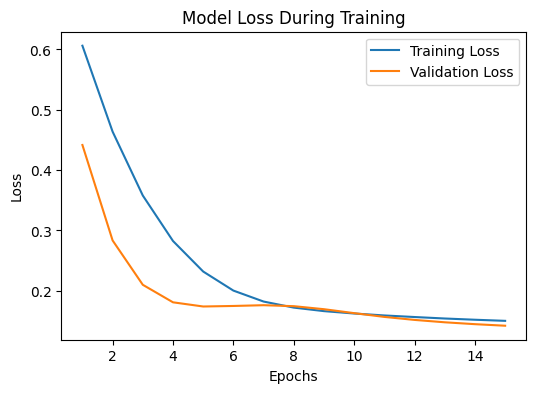

In [222]:
# Plot 1: Loss curves dengan EPOCH MAPPING 
plt.figure(figsize=(6, 4))
epochs_range = range(1, len(history.history['loss']) + 1)  
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

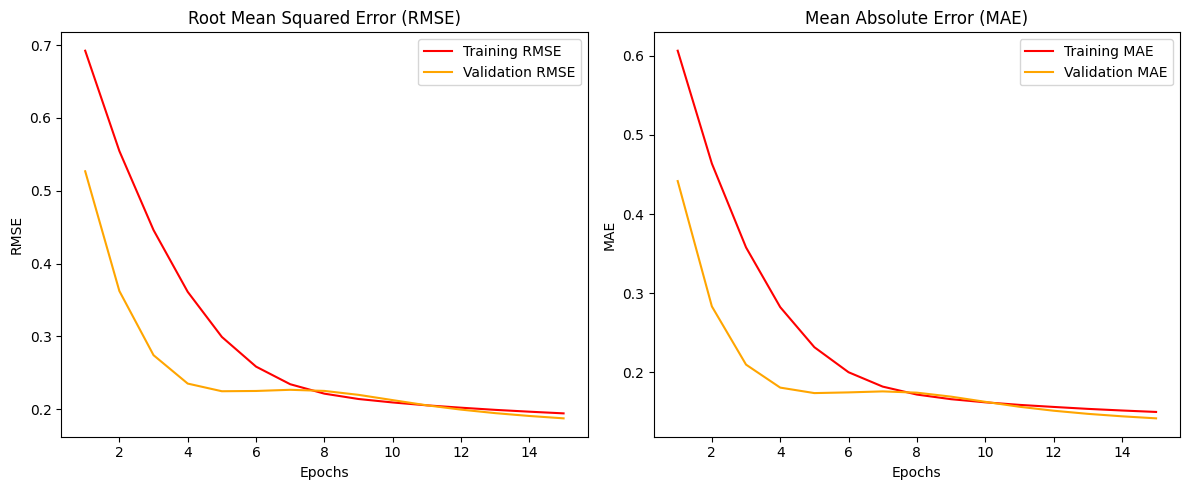

In [224]:
# Plot ERROR learning curves dengan validation metrics
plt.figure(figsize=(12, 5))  # Layout 2 subplot
epochs_range = range(1, len(history.history['root_mean_squared_error']) + 1) 

# Plot 2: RMSE
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['root_mean_squared_error'], label='Training RMSE', color='red')
plt.plot(epochs_range, history.history['val_root_mean_squared_error'], label='Validation RMSE', color='orange')
plt.title('Root Mean Squared Error (RMSE)')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

# Plot 3: MAE
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['mean_absolute_error'], label='Training MAE', color='red')
plt.plot(epochs_range, history.history['val_mean_absolute_error'], label='Validation MAE', color='orange')
plt.title('Mean Absolute Error (MAE)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

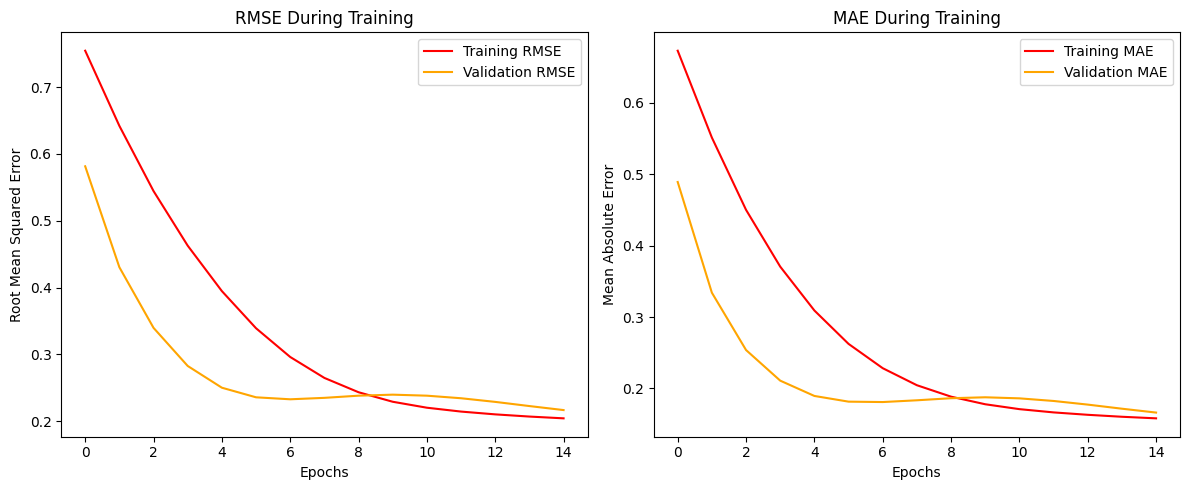

In [134]:
# Plot RMSE dan MAE
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Subplot 1: RMSE
axs[0].plot(history.history['root_mean_squared_error'], color='red', label='Training RMSE')
axs[0].plot(history.history['val_root_mean_squared_error'], color='orange', label='Validation RMSE')
axs[0].set_title('RMSE During Training')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Root Mean Squared Error')
axs[0].legend()

# Subplot 2: MAE
axs[1].plot(history.history['mean_absolute_error'], color='red', label='Training MAE')
axs[1].plot(history.history['val_mean_absolute_error'], color='orange', label='Validation MAE')
axs[1].set_title('MAE During Training')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Mean Absolute Error')
axs[1].legend()

plt.tight_layout()
plt.show()

## **Test the Results**

In [225]:
display(model.evaluate([user_vector_train_scaled, anime_vector_train_scaled], y_train_scaled, batch_size=2048))  # train
display(model.evaluate([user_vector_val_scaled, anime_vector_val_scaled], y_val_scaled, batch_size=2048))        # val
display(model.evaluate([user_vector_test_scaled, anime_vector_test_scaled], y_test_scaled, batch_size=2048))     # test

909/909 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1425 - mean_absolute_error: 0.1425 - root_mean_squared_error: 0.1880


[0.14232666790485382, 0.14232860505580902, 0.18781757354736328]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1420 - mean_absolute_error: 0.1420 - root_mean_squared_error: 0.1871


[0.14213958382606506, 0.14214132726192474, 0.18762363493442535]

179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1422 - mean_absolute_error: 0.1422 - root_mean_squared_error: 0.1876


[0.14228373765945435, 0.14228586852550507, 0.18769153952598572]

## **Predict 1**

In [226]:
# Cek user ID yang tersedia
available_users = average_user_df_score['user_id'].unique()
print(f"Jumlah user yang tersedia: {len(available_users)}")
print(f"Beberapa contoh user ID: {available_users[:10]}")

# Pilih user ID yang valid
user_id = 1
print(f"Menggunakan user ID: {user_id}")

# Ambil data preferensi user
current_user_data = average_user_df_score.loc[average_user_df_score['user_id'] == user_id, :].drop(columns='user_id')
print(f"Ukuran data user: {current_user_data.shape}")

# Duplikasi vektor user sesuai jumlah anime
current_user_vecs = np.tile(current_user_data.to_numpy(), (len(df_anime), 1))
scaled_current_user_vecs = user_scaler.transform(current_user_vecs)
print(f"Ukuran vektor user yang sudah discale: {scaled_current_user_vecs.shape}")

# Ambil vektor anime
anime_vecs = anime_one_hot_df.iloc[:, 1:].to_numpy()
scaled_anime_vecs = anime_scaler.transform(anime_vecs)
print(f"Ukuran vektor anime yang sudah discale: {scaled_anime_vecs.shape}")

# Tampilkan preferensi genre dari user
display(current_user_data)

Jumlah user yang tersedia: 21545
Beberapa contoh user ID: [ 1  4  9 20 23 37 47 48 53 66]
Menggunakan user ID: 1
Ukuran data user: (1, 22)
Ukuran vektor user yang sudah discale: (24905, 22)
Ukuran vektor anime yang sudah discale: (24905, 24)


,Adventure,Drama,Sports,Award Winning,Comedy,UNKNOWN,Mystery,Ecchi,Horror,Gourmet,...,Avant Garde,Sci-Fi,Action,Fantasy,Hentai,Supernatural,Girls Love,Romance,Boys Love,Slice of Life
0,7.8,7.5,7.9,8.0,7.2,0.0,7.6,6.8,7.3,7.6,...,8.1,7.4,7.7,7.6,6.3,7.6,6.1,7.2,0.0,7.7


In [240]:
# Pilih user ID yang valid
user_id = 1
print(f"Menggunakan user ID: {user_id}")

# Ambil data preferensi user
current_user_data = average_user_df_score.loc[average_user_df_score['user_id'] == user_id, :].drop(columns='user_id')

# Duplikasi vektor user sesuai jumlah anime
current_user_vecs = np.tile(current_user_data.to_numpy(), (len(df_anime), 1))
scaled_current_user_vecs = user_scaler.transform(current_user_vecs)

# Ambil vektor anime dan skala
scaled_anime_vecs = anime_scaler.transform(anime_one_hot_df.iloc[:, 1:].to_numpy())

# Buat prediksi dan kembalikan ke skala rating asli
y_p = model.predict([scaled_current_user_vecs, scaled_anime_vecs])
y_pu = target_scaler.inverse_transform(y_p)

# Ambil data rating user
user_ratings = df_score[df_score['user_id'] == user_id]
print(f"User ini telah menilai {len(user_ratings)} anime")

# Identifikasi anime yang sudah dinilai
user_anime_ids = user_ratings['anime_id'].tolist()
user_anime_indices = [i for i, aid in enumerate(anime_one_hot_df['anime_id']) if aid in user_anime_ids]

# Buat dataframe hasil
rated_result = pd.DataFrame({
    'anime_id': anime_one_hot_df.iloc[user_anime_indices]['anime_id'].values,
    'Rating_Prediction': y_pu[user_anime_indices].flatten()
})

# Gabungkan data dan urutkan
rated_result = (rated_result
    .merge(df_anime[['anime_id', 'Name', 'Genres', 'Score']], on='anime_id')
    .merge(user_ratings[['anime_id', 'rating']], on='anime_id')
    .rename(columns={'rating': 'User_Rating'})
    .sort_values(by='Rating_Prediction', ascending=False)
)

# Tampilkan hasil
print(f"\nTop 10 Anime yang Sudah Dinilai oleh User ID: {user_id}")
display(rated_result[['Name', 'Genres', 'Score', 'Rating_Prediction', 'User_Rating']].head(10))


Menggunakan user ID: 1
779/779 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
User ini telah menilai 262 anime

Top 10 Anime yang Sudah Dinilai oleh User ID: 1


,Name,Genres,Score,Rating_Prediction,User_Rating
173,Mushishi,"Adventure, Mystery, Slice of Life, Supernatural",8.66,9.531250,9.0
91,Sen to Chihiro no Kamikakushi,"Adventure, Award Winning, Supernatural",8.78,9.492188,10.0
0,Cowboy Bebop,"Action, Award Winning, Sci-Fi",8.75,9.484375,10.0
242,Code Geass: Hangyaku no Lelouch R2,"Action, Award Winning, Drama, Sci-Fi",8.91,9.484375,6.0
253,Hunter x Hunter (2011),"Action, Adventure, Fantasy",9.04,9.453125,9.0
179,Tonari no Totoro,"Adventure, Award Winning, Supernatural",8.25,9.453125,8.0
11,One Piece,"Action, Adventure, Fantasy",8.69,9.453125,9.0
170,Kurenai no Buta,"Action, Adventure, Award Winning, Comedy, Dram...",7.95,9.445312,9.0
251,Higashi no Eden,"Award Winning, Mystery, Romance, Sci-Fi, Suspense",7.76,9.414062,8.0
257,Shingeki no Kyojin,"Action, Award Winning, Drama, Suspense",8.54,9.406250,9.0


In [242]:
# Filter hasil rekomendasi berdasarkan genre tertentu
user_id = 1
genre_filter = "Comedy"  # Misalnya kita tertarik dengan anime genre Action
# Filter berdasarkan genre dan hanya yang sudah diberi rating
genre_rated = rated_result[(rated_result['Genres'].str.contains(genre_filter, na=False)) & 
                     (rated_result['User_Rating'].notna())]
# Urutkan berdasarkan prediksi rating tertinggi
genre_rated = genre_rated.sort_values(by='Rating_Prediction', ascending=False)
# Tampilkan hasil yang sudah dinilai oleh user
if len(genre_rated) > 0:
    print(f"\nTop 10 Anime Bergenre {genre_filter} yang Sudah Dinilai oleh User ID: {user_id}")
    display(genre_rated[['Name', 'Genres', 'Score', 'Rating_Prediction', 'User_Rating']].head(10))
    
else:
    print(f"\nUser belum menilai anime dengan genre {genre_filter}")


Top 10 Anime Bergenre Comedy yang Sudah Dinilai oleh User ID: 1


,Name,Genres,Score,Rating_Prediction,User_Rating
170,Kurenai no Buta,"Action, Adventure, Award Winning, Comedy, Dram...",7.95,9.445312,9.0
97,Samurai Champloo,"Action, Adventure, Comedy",8.51,9.195312,9.0
113,Detective Conan,"Adventure, Comedy, Mystery",8.17,9.132812,6.0
260,One Punch Man,"Action, Comedy",8.50,9.078125,8.0
164,Seihou Bukyou Outlaw Star,"Action, Adventure, Comedy, Sci-Fi",7.84,9.054688,7.0
194,Suzumiya Haruhi no Yuuutsu,"Award Winning, Comedy, Mystery, Sci-Fi",7.83,9.000000,10.0
122,Jungle wa Itsumo Hare nochi Guu Final,"Award Winning, Comedy, Slice of Life",7.62,8.960938,6.0
27,Kidou Tenshi Angelic Layer,"Award Winning, Comedy, Drama, Sci-Fi, Sports",7.26,8.875000,7.0
117,Great Teacher Onizuka,Comedy,8.69,8.867188,9.0
53,Hikaru no Go,"Comedy, Drama, Supernatural",8.08,8.867188,9.0


In [262]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def evaluate_recommendation_model(model, user_vector_test_scaled, anime_vector_test_scaled, 
                                  y_test_scaled, target_scaler, threshold=7.0, batch_size=8192):
    """
    Evaluasi kinerja model rekomendasi anime menggunakan berbagai metrik
    
    Parameters:
    - model: Model Neural Content-Based Filtering yang sudah dilatih
    - user_vector_test_scaled: Vektor user yang sudah di-scale untuk data test
    - anime_vector_test_scaled: Vektor anime yang sudah di-scale untuk data test
    - y_test_scaled: Rating sebenarnya dalam bentuk yang sudah di-scale untuk data test
    - target_scaler: Scaler yang digunakan untuk mengembalikan nilai ke skala asli
    - threshold: Ambang batas untuk klasifikasi rating baik/buruk
    - batch_size: Ukuran batch untuk prediction (default 8192)
    
    Returns:
    - Dictionary berisi berbagai metrik evaluasi
    """
    # Prediksi rating menggunakan model dengan batch_size
    y_pred_scaled = model.predict([user_vector_test_scaled, anime_vector_test_scaled], 
                                  batch_size=batch_size)
    
    # Kembalikan ke skala rating asli
    y_true = target_scaler.inverse_transform(y_test_scaled).flatten()
    y_pred = target_scaler.inverse_transform(y_pred_scaled).flatten()
    
    # Konversi rating ke label biner berdasarkan threshold
    actual_labels = (y_true >= threshold).astype(int)
    predicted_labels = (y_pred >= threshold).astype(int)
    
    # Hitung Confusion Matrix
    cm = confusion_matrix(actual_labels, predicted_labels)
    
    # Hitung metrik klasifikasi
    if len(cm.ravel()) == 4:
        tn, fp, fn, tp = cm.ravel()
    else:
        # Handle jika confusion matrix tidak berukuran 2x2
        print("Warning: Confusion matrix tidak berukuran 2x2")
        tn, fp, fn, tp = 0, 0, 0, 0
    
    # Metrik detail
    accuracy = accuracy_score(actual_labels, predicted_labels)
    
    # Tangani kasus khusus untuk precision, recall, f1
    try:
        precision = precision_score(actual_labels, predicted_labels)
        recall = recall_score(actual_labels, predicted_labels)
        f1 = f1_score(actual_labels, predicted_labels)
    except Exception as e:
        print(f"Warning calculating metrics: {e}")
        precision, recall, f1 = 0, 0, 0
    
    return {
        'confusion_matrix': cm,
        'true_positive': tp,
        'true_negative': tn,
        'false_positive': fp,
        'false_negative': fn,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

In [263]:
from IPython.display import display, HTML

def print_confusion_matrix_table(eval_results, threshold, title="Confusion Matrix Neural Content-Based Filtering"):
    """
    Menampilkan confusion matrix dalam format tabel rapi
    """
    tp = eval_results['true_positive']
    tn = eval_results['true_negative']
    fp = eval_results['false_positive']
    fn = eval_results['false_negative']
    
    # Buat tabel confusion matrix
    data = [
        ["Relevan", f"TP = {tp}", f"TN = {tn}"],
        ["Tidak Relevan", f"FP = {fp}", f"FN = {fn}"]
    ]
    
    df = pd.DataFrame(data, columns=["Kelas Relevansi", "Terekomendasikan", "Tidak Terekomendasikan"])
    
    # Tampilkan dengan header multi-indeks
    header = pd.MultiIndex.from_arrays([
        ["", "Kelas Rekomendasi", "Kelas Rekomendasi"],
        ["Kelas Relevansi", "Terekomendasikan", "Tidak Terekomendasikan"]
    ])
    
    df_styled = pd.DataFrame(data, columns=header)
    df_styled = df_styled.style.set_caption(f"Tabel {title} (Threshold = {threshold})")
    
    display(df_styled)
    
    # Tampilkan metrik evaluasi dalam tabel
    metrics = {
        "Accuracy": eval_results['accuracy'],
        "Precision": eval_results['precision'],
        "Recall": eval_results['recall'],
        "F1-Score": eval_results['f1_score']
    }
    
    df_metrics = pd.DataFrame(metrics.items(), columns=["Metrik", "Nilai"])
    df_metrics["Nilai"] = df_metrics["Nilai"].apply(lambda x: f"{x:.4f}")
    
    print(f"\nHasil Evaluasi dengan Threshold {threshold}:")
    display(df_metrics)

In [264]:
# Evaluasi untuk Neural Content-Based Filtering dengan berbagai threshold
thresholds = [6.0, 6.5, 7.0]  # Mengubah threshold sesuai permintaan

# Untuk menyimpan hasil semua threshold
all_results = {}
for threshold in thresholds:
    # Evaluasi model dengan threshold tertentu
    eval_results = evaluate_recommendation_model(
        model=model,
        user_vector_test_scaled=user_vector_test_scaled, 
        anime_vector_test_scaled=anime_vector_test_scaled,
        y_test_scaled=y_test_scaled,
        target_scaler=target_scaler,
        threshold=threshold
    )
    
    # Simpan hasil
    all_results[threshold] = eval_results
    
    # Tampilkan dalam format tabel
    print(f"\n=== Threshold {threshold} ===")
    print_confusion_matrix_table(eval_results, threshold)

# Tampilkan perbandingan semua threshold dalam satu tabel
print("\n=== Perbandingan Hasil untuk Semua Threshold ===")
comparison = {
    "Threshold": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": []
}
for threshold, results in all_results.items():
    comparison["Threshold"].append(threshold)
    comparison["Accuracy"].append(f"{results['accuracy']:.4f}")
    comparison["Precision"].append(f"{results['precision']:.4f}")
    comparison["Recall"].append(f"{results['recall']:.4f}")
    comparison["F1-Score"].append(f"{results['f1_score']:.4f}")

df_comparison = pd.DataFrame(comparison)
display(df_comparison)

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

=== Threshold 6.0 ===



Hasil Evaluasi dengan Threshold 6.0:


,Metrik,Nilai
0,Accuracy,0.8861
1,Precision,0.8953
2,Recall,0.9876
3,F1-Score,0.9392


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

=== Threshold 6.5 ===



Hasil Evaluasi dengan Threshold 6.5:


,Metrik,Nilai
0,Accuracy,0.7703
1,Precision,0.7794
2,Recall,0.9759
3,F1-Score,0.8667


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

=== Threshold 7.0 ===



Hasil Evaluasi dengan Threshold 7.0:


,Metrik,Nilai
0,Accuracy,0.7632
1,Precision,0.7939
2,Recall,0.9324
3,F1-Score,0.8576



=== Perbandingan Hasil untuk Semua Threshold ===


,Threshold,Accuracy,Precision,Recall,F1-Score
0,6.0,0.8861,0.8953,0.9876,0.9392
1,6.5,0.7703,0.7794,0.9759,0.8667
2,7.0,0.7632,0.7939,0.9324,0.8576


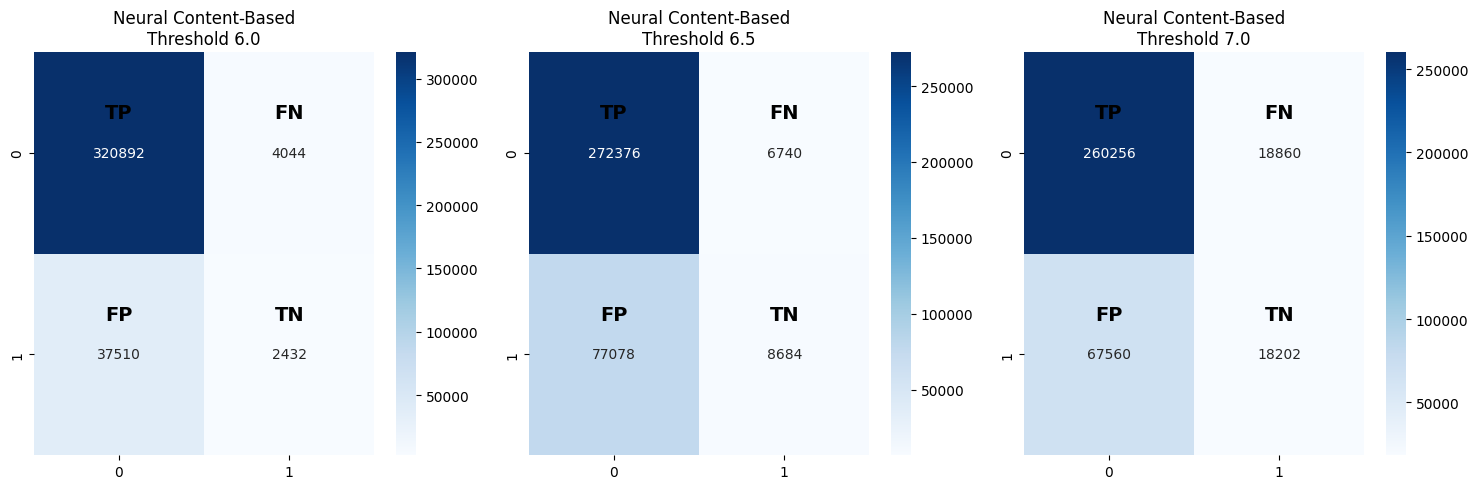

In [265]:
# Cell 4: Visualisasi Confusion Matrix untuk Neural Content-Based Filtering
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, threshold in enumerate(all_results.keys()):
    results = all_results[threshold]
    tn, fp, fn, tp = results['true_negative'], results['false_positive'], results['false_negative'], results['true_positive']
    cm_standard = np.array([[tp, fn], [fp, tn]])
    
    sns.heatmap(cm_standard, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].text(0.5, 0.3, 'TP', ha='center', va='center', fontsize=14, fontweight='bold', color='black')
    axes[idx].text(1.5, 0.3, 'FN', ha='center', va='center', fontsize=14, fontweight='bold', color='black')
    axes[idx].text(0.5, 1.3, 'FP', ha='center', va='center', fontsize=14, fontweight='bold', color='black')
    axes[idx].text(1.5, 1.3, 'TN', ha='center', va='center', fontsize=14, fontweight='bold', color='black')
    axes[idx].set_title(f'Neural Content-Based\nThreshold {threshold}')

plt.tight_layout()
plt.show()

## **Persiapan Data untuk Hybrid**

In [88]:
import numpy as np
from scipy import sparse
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Cek ketersediaan komponen
print(f"Model NCBF: {'model' in globals()}")
print(f"Sparse matrix akan dibuat baru")

Model NCBF: True
Sparse matrix akan dibuat baru


## Inisialisasi Matriks Sparse

In [89]:
# mengidentifikasi semua user dan anime unik

print("Creating user-item interaction matrix...")
unique_users = df_score['user_id'].unique()
unique_animes = df_anime['anime_id'].unique()
print(f"Jumlah users unik: {len(unique_users)}")
print(f"Jumlah anime unik: {len(unique_animes)}")

Creating user-item interaction matrix...
Jumlah users unik: 21545
Jumlah anime unik: 24905


In [81]:
from scipy import sparse

# Create mappings for user_id and anime_id to matrix indices
user_to_index = {user: i for i, user in enumerate(unique_users)}
anime_to_index = {anime: i for i, anime in enumerate(unique_animes)}
index_to_user = {i: user for user, i in user_to_index.items()}
index_to_anime = {i: anime for anime, i in anime_to_index.items()}

# Create data matrix for the DMF model
num_users = len(unique_users)
num_animes = len(unique_animes)
# Gunakan sparse matrix untuk efisiensi memori

data_matrix = sparse.lil_matrix((num_users, num_animes))

In [87]:
# Buat matriks untuk penyimpanan rating
num_users = len(user_to_index)
num_animes = len(anime_to_index)
print(f"Membuat matriks {num_users} x {num_animes}")

# Matriks original (dengan rating asli)
ratings = df_score['rating'].values
user_indices = np.array([user_to_index[u] for u in df_score['user_id']])
anime_indices = np.array([anime_to_index[a] for a in df_score['anime_id']])

# Gunakan rating original 1-10 tanpa normalisasi
original_ratings = ratings  # Langsung pakai rating 1-10

# Buat matriks sparse
data_matrix = sparse.csr_matrix(
    (original_ratings, (user_indices, anime_indices)), 
    shape=(num_users, num_animes)
)

print(f"Matrix shape: {data_matrix.shape}")
print(f"Densitas: {100 * data_matrix.count_nonzero() / (num_users * num_animes):.4f}%")
print(f"Rating range: Min={np.min(original_ratings):.0f}, Max={np.max(original_ratings):.0f}, Mean={np.mean(original_ratings):.4f}")

Membuat matriks 21545 x 24905
Matrix shape: (21545, 24905)
Densitas: 0.4533%
Rating range: Min=1, Max=10, Mean=7.4885


## Fungsi Prediksi Batch

In [88]:
def predict_ratings(uids, aids, batch=32768):
    """Prediksi rating untuk pasangan user-anime dalam batch optimal untuk GPU"""
    n = len(uids)
    preds = np.zeros(n)
    
    # Inisialisasi cache sekali saja
    if not hasattr(predict_ratings, 'user_cache'):
        predict_ratings.user_cache = {}
        predict_ratings.anime_cache = {}
        predict_ratings.feature_dims = {
            'user': average_user_df_score.iloc[:,1:].shape[1],
            'anime': anime_one_hot_df.iloc[:,1:].shape[1]
        }
        predict_ratings.id_maps = {
            'user_id_map': {},
            'anime_id_map': {}
        }
    
    user_cache = predict_ratings.user_cache
    anime_cache = predict_ratings.anime_cache
    
    # Proses dalam batch untuk efisiensi GPU
    for i in range(0, n, batch):
        end = min(i+batch, n)
        batch_size = end-i
        
        # Persiapkan arrays fitur
        u_feat = np.zeros((batch_size, predict_ratings.feature_dims['user']))
        a_feat = np.zeros((batch_size, predict_ratings.feature_dims['anime']))
        batch_uids = uids[i:end]
        batch_aids = aids[i:end]
        
        # Cache fitur untuk setiap user yang unik
        for j, uid in enumerate(np.unique(batch_uids)):
            if uid not in user_cache:
                user_id = predict_ratings.id_maps['user_id_map'].get(uid) or index_to_user[uid]
                user_cache[uid] = average_user_df_score.loc[average_user_df_score['user_id'] == user_id].iloc[:,1:].values[0]
        
        # Cache fitur untuk setiap anime yang unik
        for j, aid in enumerate(np.unique(batch_aids)):
            if aid not in anime_cache:
                anime_id = predict_ratings.id_maps['anime_id_map'].get(aid) or index_to_anime[aid]
                anime_cache[aid] = anime_one_hot_df.loc[anime_one_hot_df['anime_id'] == anime_id].iloc[:,1:].values[0]
        
        # Assign fitur dari cache ke batch arrays
        for j in range(batch_size):
            u_feat[j] = user_cache[batch_uids[j]]
            a_feat[j] = anime_cache[batch_aids[j]]
        
        # Scale, predict, dan unscale rating
        u_scaled = user_scaler.transform(u_feat)
        a_scaled = anime_scaler.transform(a_feat)
        p_scaled = model.predict([u_scaled, a_scaled], verbose=0, batch_size=4096)
        p_orig = target_scaler.inverse_transform(p_scaled).flatten()
        
        # Gunakan rating original 1-10 tanpa normalisasi
        preds[i:end] = np.clip(p_orig, 1, 10)
    
    return preds

## Fill Matrix

In [89]:
def fill_matrix(matrix, n_items=200, max_users=None):
    """Isi matriks sparse dengan prediksi rating untuk meningkatkan densitas"""
    start_time = time.time()
    filled = matrix.tolil()  # Format efisien untuk pengisian matriks
    rows, cols = filled.shape
    
    # Tentukan range pengguna (semua atau dibatasi)
    user_range = range(min(max_users, rows) if max_users else rows)
    print(f"Mengisi matriks untuk {len(user_range)} dari {rows} users...")
    
    # Variabel untuk tracking
    total_added = 0
    last_progress_time = time.time()
    batch_size = 100000  # Ukuran batch optimal untuk GPU
    
    # Alokasi memory untuk batch
    batch_users = np.zeros(batch_size, dtype=np.int32)
    batch_items = np.zeros(batch_size, dtype=np.int32)
    batch_info = []
    batch_idx = 0
    rated_cache = {}  # Cache untuk item yang sudah dirating
    
    # Proses setiap user
    for i, user_idx in enumerate(user_range):
        # Tampilkan progres per 1000 user atau 30 detik
        if i % 1000 == 0 and i > 0 or (time.time() - last_progress_time > 30 and i > 0):
            elapsed = time.time() - start_time
            rate = i / elapsed if elapsed > 0 else 0
            current_density = 100 * (matrix.count_nonzero() + total_added) / (rows * cols)
            eta_minutes = int((len(user_range) - i) / rate / 60) if rate > 0 else 0
            
            print(f"User {i:,}/{len(user_range):,} ({100*i/len(user_range):.1f}%) - {rate:.1f} u/s - Densitas: {current_density:.4f}% - ETA: {eta_minutes}m")
            last_progress_time = time.time()
        
        # Dapatkan item yang belum dirating
        if user_idx not in rated_cache:
            rated_cache[user_idx] = set(filled.rows[user_idx])
        
        # Pilih n_items untuk diprediksi
        unrated = list(set(range(cols)) - rated_cache[user_idx])
        if not unrated: continue
        items = np.random.choice(unrated, min(n_items, len(unrated)), replace=False)
        
        # Proses batch jika akan overflow
        if batch_idx + len(items) > batch_size:
            preds = predict_ratings(batch_users[:batch_idx], batch_items[:batch_idx])
            for idx, (u, a) in enumerate(batch_info):
                filled[u, a] = preds[idx]
                total_added += 1
            batch_idx, batch_info = 0, []
        
        # Tambahkan ke batch
        for item in items:
            batch_users[batch_idx] = user_idx
            batch_items[batch_idx] = item
            batch_info.append((user_idx, item))
            batch_idx += 1
    
    # Proses batch terakhir
    if batch_idx > 0:
        preds = predict_ratings(batch_users[:batch_idx], batch_items[:batch_idx])
        for idx, (u, a) in enumerate(batch_info):
            filled[u, a] = preds[idx]
            total_added += 1
    
    # Tampilkan hasil
    elapsed = time.time() - start_time
    minutes, seconds = divmod(int(elapsed), 60)
    hours, minutes = divmod(minutes, 60)
    densitas = 100 * filled.count_nonzero() / (rows * cols)
    
    print(f"Selesai dalam {hours}h {minutes}m {seconds}s")
    print(f"Total {total_added:,} rating ditambahkan")
    print(f"Densitas mencapai {densitas:.4f}%")
    
    return filled.tocsr(), total_added

In [90]:
import time

# Eksekusi - perhatikan parameter max_users
enhanced_matrix, added_ratings = fill_matrix(
    data_matrix,
    n_items=200,      # Prediksi 200 item per user
    max_users=None    # Batasi 
)  

# Tampilkan hasil
print(f"Matrix shape: {enhanced_matrix.shape}")
print(f"Rating original: {data_matrix.count_nonzero():,}")
print(f"Rating setelah penambahan: {enhanced_matrix.count_nonzero():,}")
print(f"Densitas awal: {100*data_matrix.count_nonzero()/(num_users*num_animes):.4f}%")
print(f"Densitas akhir: {100*enhanced_matrix.count_nonzero()/(num_users*num_animes):.4f}%")

Mengisi matriks untuk 21545 dari 21545 users...
User 1,000/21,545 (4.6%) - 64.5 u/s - Densitas: 0.4720% - ETA: 5m
User 2,000/21,545 (9.3%) - 94.3 u/s - Densitas: 0.5092% - ETA: 3m
User 3,000/21,545 (13.9%) - 111.6 u/s - Densitas: 0.5465% - ETA: 2m
User 4,000/21,545 (18.6%) - 123.1 u/s - Densitas: 0.5838% - ETA: 2m
User 5,000/21,545 (23.2%) - 131.0 u/s - Densitas: 0.6211% - ETA: 2m
User 6,000/21,545 (27.8%) - 136.7 u/s - Densitas: 0.6583% - ETA: 1m
User 7,000/21,545 (32.5%) - 140.4 u/s - Densitas: 0.6956% - ETA: 1m
User 8,000/21,545 (37.1%) - 143.6 u/s - Densitas: 0.7329% - ETA: 1m
User 9,000/21,545 (41.8%) - 146.3 u/s - Densitas: 0.7702% - ETA: 1m
User 10,000/21,545 (46.4%) - 148.5 u/s - Densitas: 0.8074% - ETA: 1m
User 11,000/21,545 (51.1%) - 150.3 u/s - Densitas: 0.8447% - ETA: 1m
User 12,000/21,545 (55.7%) - 151.8 u/s - Densitas: 0.8820% - ETA: 1m
User 13,000/21,545 (60.3%) - 153.1 u/s - Densitas: 0.9193% - ETA: 0m
User 14,000/21,545 (65.0%) - 154.2 u/s - Densitas: 0.9565% - ETA: 0m

In [91]:
# Hitung sparsity matrix
original_sparsity = 100 - (100 * data_matrix.count_nonzero() / (num_users * num_animes))
enhanced_sparsity = 100 - (100 * enhanced_matrix.count_nonzero() / (num_users * num_animes))

print(f"Sparsity awal: {original_sparsity:.4f}%")
print(f"Sparsity akhir: {enhanced_sparsity:.4f}%")
print(f"Pengurangan sparsity: {original_sparsity - enhanced_sparsity:.4f}%")

Sparsity awal: 99.5467%
Sparsity akhir: 98.7436%
Pengurangan sparsity: 0.8031%


In [92]:
# Cek prediksi untuk user tertentu 
user_idx = 100 # baris dalam matrix

# Bandingkan rating asli vs prediksi
orig = data_matrix[user_idx].toarray().flatten()
pred = enhanced_matrix[user_idx].toarray().flatten()
changed = np.where((orig == 0) & (pred > 0))[0]

# Tampilkan hasil
print(f"User {user_idx}: {len(changed)} prediksi")
if len(changed) > 0:
    print("Anime | Original | Prediksi")
    print("-" * 30)
    for idx in changed[:5]:  # 5 prediksi pertama
        print(f"{idx:5d} | 0.0000 | {pred[idx]:.4f}")

# Statistik densitas
print(f"\nDensitas: {100*data_matrix.count_nonzero()/(data_matrix.shape[0]*data_matrix.shape[1]):.4f}% → "
      f"{100*enhanced_matrix.count_nonzero()/(enhanced_matrix.shape[0]*enhanced_matrix.shape[1]):.4f}%")

User 100: 200 prediksi
Anime | Original | Prediksi
------------------------------
    8 | 0.0000 | 8.6094
   68 | 0.0000 | 7.3906
   98 | 0.0000 | 7.0703
  127 | 0.0000 | 7.9531
  259 | 0.0000 | 8.0391

Densitas: 0.4533% → 1.2564%


## Visualisasi & Simpan

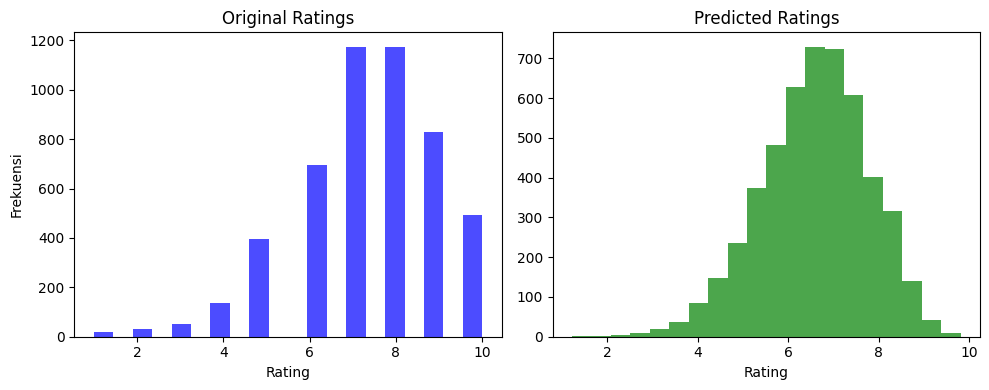

In [93]:
# Plot distribusi
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Sample ratings
sample_size = 5000
orig = data_matrix.data[:sample_size] if len(data_matrix.data) > sample_size else data_matrix.data

# Get predicted ratings (sample dari matrix yang diisi)
orig_nnz = data_matrix.count_nonzero()
enhanced_nnz = enhanced_matrix.count_nonzero()

if enhanced_nnz > orig_nnz:
    # Konversi ke format array untuk mempermudah sampling
    enhanced_arr = enhanced_matrix.toarray()
    data_arr = data_matrix.toarray()
    
    # Cari posisi nilai yang baru ditambahkan
    mask = (data_arr == 0) & (enhanced_arr != 0)
    
    # Ambil sampel dari rating yang diprediksi
    y_idx, x_idx = np.where(mask)
    if len(y_idx) > sample_size:
        indices = np.random.choice(len(y_idx), sample_size, replace=False)
        pred_ratings = [enhanced_arr[y_idx[i], x_idx[i]] for i in indices]
    else:
        pred_ratings = [enhanced_arr[y, x] for y, x in zip(y_idx, x_idx)]
else:
    pred_ratings = []

# Plot
ax[0].hist(orig, bins=20, color='blue', alpha=0.7)
ax[0].set_title('Original Ratings')
ax[0].set_xlabel('Rating')
ax[0].set_ylabel('Frekuensi')

if pred_ratings:
    ax[1].hist(pred_ratings, bins=20, color='green', alpha=0.7)
else:
    ax[1].text(0.5, 0.5, "Tidak ada rating prediksi", 
               ha='center', va='center', transform=ax[1].transAxes)
ax[1].set_title('Predicted Ratings')
ax[1].set_xlabel('Rating')

plt.tight_layout()
plt.show()



In [100]:
# Save matrix
sparse.save_npz('enhanced_matrix_dmf.npz', enhanced_matrix)
print("Matriks berhasil disimpan dan siap untuk model Hybrid DMF!")

Matriks berhasil disimpan dan siap untuk model Hybrid DMF!


## **Save Model**

In [ ]:
# # Save model to h5 file
# model.save('content_based.h5')

In [ ]:
# # Check loaded model
# new_model = tf.keras.models.load_model('content_based.h5')

In [ ]:
# # Evaluasi model pada data anime
# # Check loaded model
# print("Evaluasi Model:")
# print("Training Set:")
# display(new_model.evaluate([user_vector_train_scaled, anime_vector_train_scaled], y_train_scaled))  # train

# print("Validation Set:")
# display(new_model.evaluate([user_vector_val_scaled, anime_vector_val_scaled], y_val_scaled))        # val

# print("Test Set:")
# display(new_model.evaluate([user_vector_test_scaled, anime_vector_test_scaled], y_test_scaled))     # test